CS-E5885 Modeling biological networks (spring 2023)

In [4]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.linalg import expm
from scipy.optimize import least_squares

In [5]:
data = pd.read_csv('data.csv', header = 0)

In [6]:
data.head()

,Time/gene,SWI5,CBF1,GAL4,GAL80,ASH1
0,0,0.0760,0.0419,0.0207,0.0225,0.1033
1,10,0.0186,0.0365,0.0122,0.0175,0.0462
2,20,0.0090,0.0514,0.0073,0.0165,0.0439
3,30,0.0117,0.0473,0.0079,0.0147,0.0371
4,40,0.0088,0.0482,0.0084,0.0145,0.0475


In [7]:
t_data = data['Time/gene'].to_numpy()
Y_data = data.drop(columns = ['Time/gene']).to_numpy()

## First view of the data

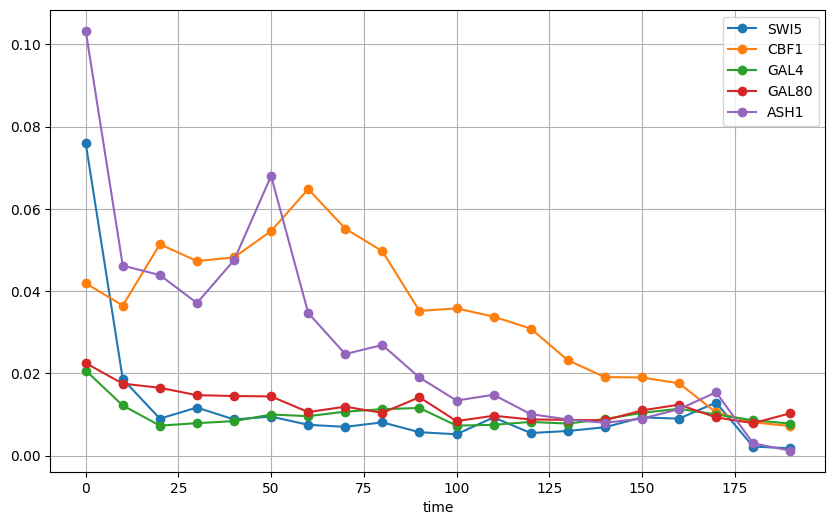

In [8]:
#observe data

plt.figure(figsize=(10,6))
plt.plot(t_data, Y_data, marker = "o")
plt.legend(data.columns[1:])
plt.xlabel('time')
plt.grid()
plt.show()

In [6]:
#observations:

## exo 5

## Choice of the first model - density karnel and arcne algorithm

#### Karnel dentsity to estimat the density of our data

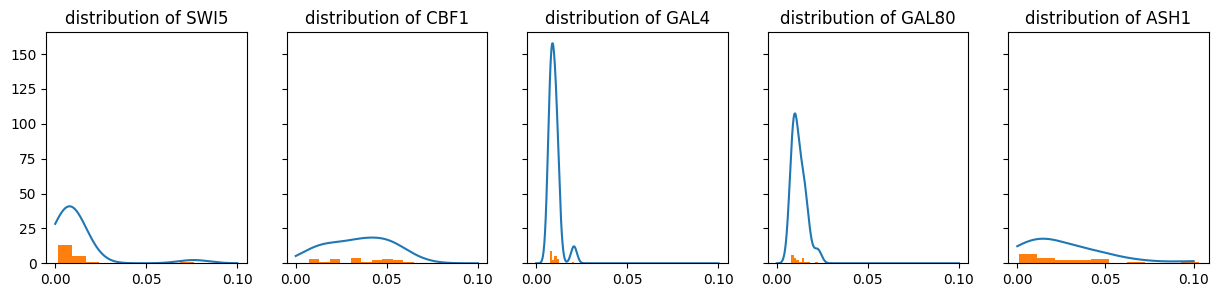

In [9]:
from scipy.stats import norm, gaussian_kde

#preparing the plot
t = np.linspace(0, 0.1, 500)
fig, axs = plt.subplots(1, 5,figsize=(15, 3), sharey=True)

#init list of karnel density for each varrible
densities = []

#the bandwith 
bw = []


for i in range(Y_data.shape[1]) : #for each genes
    
    #estimate the ditribution
    scipy_karnel = gaussian_kde(Y_data[:,i])
    densities.append(scipy_karnel)
    y= scipy_karnel.evaluate(t)
    
    #plot the histogram of the y values and the distributions
    axs[i].plot(t,y)
    axs[i].hist(Y_data[:,i])

    #title and legend
    axs[i].set_title(f'distribution of {data.columns[1+i]}')
    
    #estimate the bandwith
    bw.append(scipy_karnel.factor * np.std(Y_data[:,i]))

#### Mutual information computation

In [10]:
#mutual information is given by sum(p(x,y) log(p(x,y)/p(x)p(y)))

def MI(pmfx,pmfy) : 
    '''
    Compute the mutual inforamtion between the varriable X and Y using their probability 
    mass function. and the joint probability mass function.
    
    pmfx : probability mass function of X
    pmfy : probability mass funciton of Y
    
    return float
    '''

#### Multistart algorithm for the first model

Our model is represented by a matrix 5x5 composed by 1 or 0. The element $M_{ij} = 1$ means gene i impact gene j.

We're going to generate 3 starting matrix using the observation that we can do about the data behavor and the biological knowlege that we have.
- we can oberve that varriables seems more correlated than others. Behavor of Gal4 and Gal80 (elements 3 and 4 of the data) seems the same. we will generate randomly with a proba p = 0.8 to have a 1 between element i,j = {3,4}.
- We want to remove the auto-regulation

In [30]:
def multistart_generation(N):
    '''
    generate a list of N starting matrix according to the condition.
    
    return : 
    list of N matrix 5x5 with 1 or 0 value
    '''
    M = []
    for i in range(N): M.append(np.zeros((5,5)))
    
    for m in M:
        for i in range(5) :
            for j in range(5):
                if (j == 3 or j== 4) and (i==3 or i == 4) : 
                    m[i][j] = np.random.choice([0, 1], p=[.2, .8]) #gal4 and gal80 may interact
                else : m[i][j] = np.random.choice([0, 1], p=[.5, .5]) 
                
                #if i == j : m[i][j] = 0 #remove the auto-regulation
                if i == j : m[i][j] = 1 #force inversible model
                
    return M

we can visualize our matrix using a confusion metrics

In [12]:
import networkx as nx

def vizualize_model(m, index):
    '''
    vizualize the structure of the model m
    
    paramter: 
    m: model matrix 5x5
    
    return: 
    non
    
    '''
    label = data.columns[1:]
    G = nx.DiGraph() #creat a directed graph
    
    G.add_nodes_from(label)
    
    for i in range(m.shape[0]) :
        for j in range(m.shape[1]):
            if m[i][j] ==1 : G.add_edge(label[i], label[j], weight=1)
                
    pos = nx.spring_layout(G)          
    nx.draw_networkx_labels(G,pos)
    nx.draw_networkx_nodes(G, pos, cmap=plt.get_cmap('jet'),node_color = "pink", node_size = 500)
    nx.draw_networkx_edges(G, pos, edge_color='black', arrows=True)
    plt.title(f"starting model strucutre {index +1}")
    plt.show()


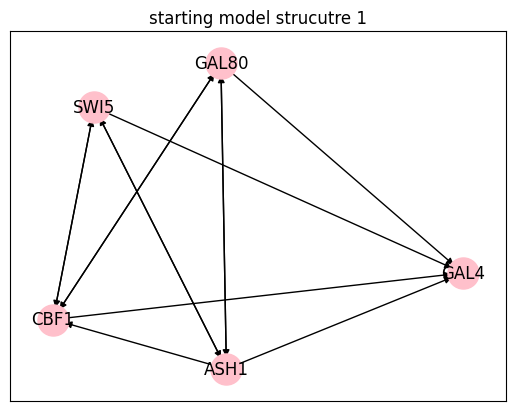

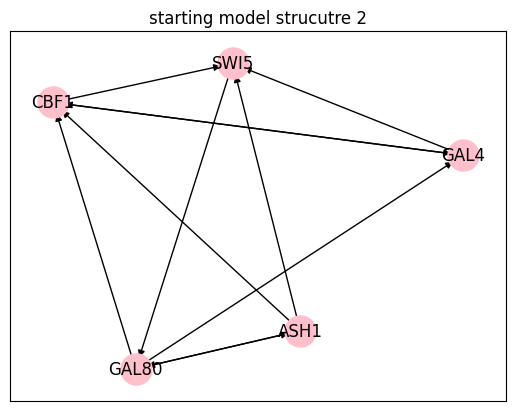

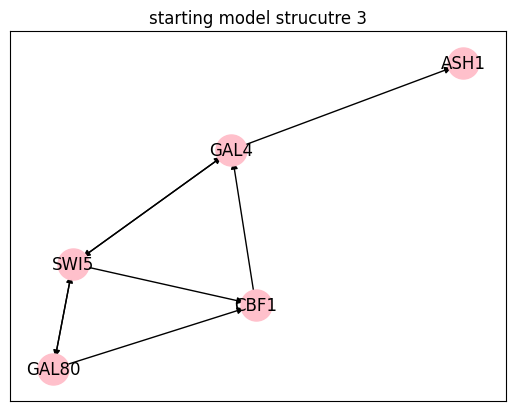

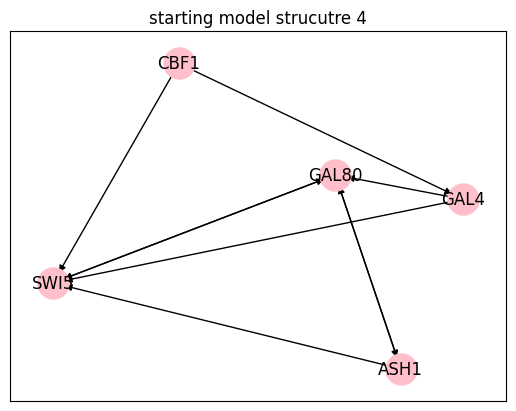

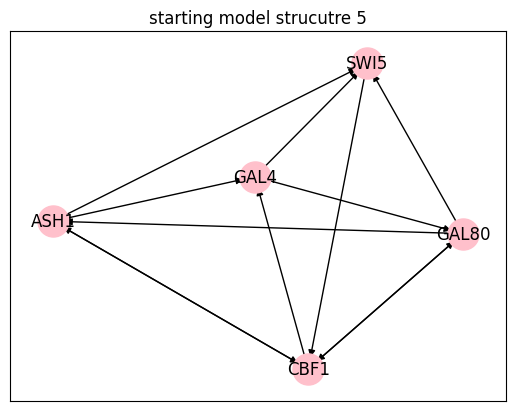

In [13]:
#TEST : 
M = multistart_generation(5)
for i in range(len(M)) : 
    vizualize_model(M[i], i)

In [14]:
#vizalization of the average of the interactions
M_average = sum(M)/len(M)
average_data = pd.DataFrame(M_average, index=data.columns[1:], columns=data.columns[1:])
average_data.head()

,SWI5,CBF1,GAL4,GAL80,ASH1
SWI5,0.0,0.6,0.4,0.6,0.2
CBF1,0.6,0.0,1.0,0.4,0.2
GAL4,0.8,0.2,0.0,0.4,0.2
GAL80,0.6,0.8,0.4,0.0,0.8
ASH1,0.8,0.6,0.4,0.6,0.0


## Structure optimization : voisin algo and bootstramp

We're using the greedy hill algorithm to find the best structure for our system. We're optimize the matrix M.

In [46]:
def greedy_hill_climbing(M) :
    ''' 
    Creat the neighboring of M and give the optimized graphe.
    
    parameter : 
    M: the starting graph
    
    return : 
    M_otp the optimized graph
    '''
    nhb = neighborhood(M)
    M_opt = M
    
    for m in nhb:
        if score(m) > score(M_opt) : M_opt = m
    
    return M_opt

In [44]:
def neighborhood(M):
    '''
    compute the newborns of M.  
    - add a reaction 0->1
    - delete a reaction 1->0
    
    parameter :
    M : the initial strucutre
    
    return:
    nhb : list of the neihgbor of M. size = size(M)*size(M)
    '''
    M_ = M # a copy of M
    nhb = []
    for i in range(M.shape[0]):
        for j in range(M.shape[1]):
            if M[i][j] ==0 : M_[i][j]= 1
            else : M_[i][j]= 0
            if (np.linalg.det(M_) != 0):
                nhb.append(M_) #add the neighbor of M 
            M_ = M #come back to M to change the next value at the next step
    print('neighborhood size :', len(nhb)) 
            
    return nhb

#TEST
opt_M = []
s = []
for m in M : 
    opt_M.append(greedy_hill_climbing(m)) #we run the algorithm for each of the starting matrix 
    s.append(score(M)) #compute the score of the optimized matrix

best_M = opt_M[s.index(max(s))]

## ODE and optimization of the parameters k 

### Use matrix models

We want to try and infer wich protein migt interact with wich. A model M is represented by a 5x5 binary matrix, where 1 represents an interaction of columns --> row.
We are using here linear differential equation to represent the evolution of each molecule over time.

\begin{align*}
\frac{\text{d} \textbf{x}(t)}{\text{d} t} = A^M \textbf{x}(t) + \textbf{b}
\end{align*}


There exist $2^{25}$ models

In [18]:
def create_A_b(M, theta):
    """"Create matrix A and vector b.
    
    :param M: a binary numpy array with shape (5,5)
    :param theta: a list with lenght equal to 5 + number of ones in M
    :returns: A = numpy array with shape (5,5) and b = numpy array with shape (5,1).
    Data type of returned arrays must be float.
    """
    param = 5
    A = np.zeros((param,param))
    
    for i in range(5):
        for j in range(5):
            if M[i][j] == 1 :
                #print(theta[param])
                A[i][j] = theta[param]
                param += 1
            
    
    b = np.reshape(theta[:5],(5,1)) 
    return A, b

In [19]:
x_init = np.array([[0,1.0,0,1,0]]).T 

# x_init, t_data, and Y_data are global variables which can be used inside
# functions and should not be overwritten by your code

def solve_linear_ode(A, b, t):
    """Solves the linear ODE, defined by matrix A and vector b, at time points t.
    
    :param A: a numpy array with shape (5,5)
    :param b: a numpy array with shape (5,1)
    :param t: a one-dimensional numpy array containing output time points t_i
    :returns: a numpy array with shape (len(t),5), containing solutions x(t_i) as rows
    """
    L = len(t)
    X_out = np.zeros((L, 5))
    x_star = np.linalg.solve(A, -b) # solve steady state x_star = - A^{-1} b
    for j in range(L):
        xj = x_star + expm(A*t[j])@(x_init - x_star)
        X_out[j,:] = xj.flatten()
    return(X_out)

def solve_system(M, theta, t):
    """"Solve dynamics of model M with parameters theta.
    
    :param M: a binary numpy array with shape (5,5)
    :param theta: a list with lenght equal to 3 + number of ones in M
    :param t: a one-dimensional numpy array containing output time points t_i
    :returns: a numpy array with shape (len(t),5), containing solutions x(t_i) as rows
    """
    A, b = create_A_b(M,theta)
    return solve_linear_ode(A,b,t)
    

In [20]:
def log_likelihood(M, theta):
    """"Compute log-likelihood of model M with parameters theta.
    
    :param M: a binary numpy array with shape (3,3)
    :param theta: a list with lenght equal to 3 + number of ones in M
    :returns: one number
    """
 
    X_out = solve_system(M, theta, t_data)

    sigma = 0.15
    N = Y_data.size 
    
    log_lik = N*-np.log(sigma*np.sqrt(2*np.pi)) - 1/(2*pow(sigma,2)) * np.sum(np.square((Y_data-X_out).flatten()))
    
    return(log_lik)

In [21]:
def residuals(M, theta):
    """"Input function for least-squares optimization.
    
    :param M: a binary numpy array with shape (3,3)
    :param theta: a list with lenght equal to 3 + number of ones in M
    :returns: vector of all residuals (y_ij - mu_ij), has shape (3*N, ) 
    """
    X_out = solve_system(M, theta, t_data)
    residuals = (Y_data - X_out).flatten()
    
    return(residuals)

In [22]:
def fit_model(M):
    """"Find maximum likelihood parameters for model M.
    
    :param M: a binary numpy array with shape (5,5)
    :returns: maximum likelihood parameters, a list with lenght equal to 5 + number of ones in M 
    """
    theta_0 = list(np.random.normal(loc=0.05,scale=0.01,size=(5+np.count_nonzero(M),)))
    residual_fun_M = lambda theta: residuals(M, theta)
    fmin = least_squares(residual_fun_M, theta_0)
    print(fmin.message)
    return fmin.x 

In [23]:
def BIC(M, theta_ML):
    """"Bayesian Information Criterion approximation for log marginal likelihood of M.
    
    :param M: a binary numpy array with shape (3,3)
    :param theta_ML: maximum likelihood parameters for model M, a list with 
    lenght equal to 3 + number of ones in M
    :returns: one number
    """

    n = len(t_data)
    d = len(theta_ML)
    sigma_square = log_likelihood(M,theta_ML)
    
    bic = d*np.log(n) -2*sigma_square

    return(bic)

In [24]:
def plot_fit(M, theta_ML):
    """"Visualize maximum likelihood fit of model M.
    
    :param M: a binary numpy array with shape (5,5)
    :param theta_ML: maximum likelihood parameters for model M, a list with 
    lenght equal to 5 + number of ones in M
    :returns: nothing
    """
    ttt = np.linspace(0, max(t_data), 100)
    mu = solve_system(M, theta_ML, ttt)
    plt.figure(figsize=(10,5))
    LL = log_likelihood(M, theta_ML)
    bic = BIC(M, theta_ML)
    cols = ["#e41a1c", "#377eb8", "#4daf4a",'green','purple']
    for j in range(0, 5):
        plt.plot(ttt, mu[:,j], color = cols[j])
        plt.plot(t_data, Y_data[:,j], marker = "o", color = cols[j], linestyle = "none")
    plt.legend(('X1_fit', 'X1_data', 'X2_fit', 'X2_data', 'X3_fit', 'X3_data','X4_fit', 'X4_data','X5_fit', 'X5_data'))
    plt.title("LL = " + str(round(LL, 5)) + ", BIC = " + str(round(bic, 5)))
    plt.show()

In [48]:
def score(M):
    """"Returns the negative BIC of the model M
    
    :param M: a binary numpy array with shape (5,5)
    :returns: -BIC
    """
    #return a score where high = it is better
    return -BIC(M,fit_model(M))

### Tests

`xtol` termination condition is satisfied.


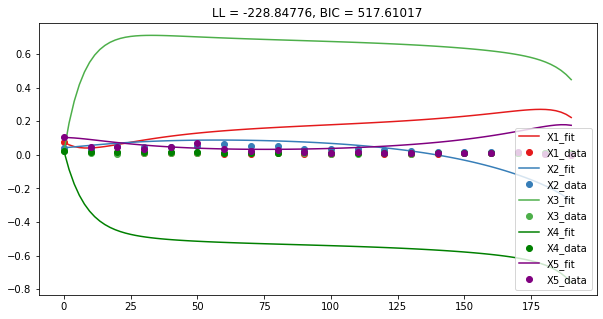

In [80]:
M0 = np.array([[1,0,1,1,1], [0,1,0,0,1], [1,0,1,1,0],[1,0,1,1,0],[1,1,0,0,1]])
theta_ML = fit_model(M0)
plot_fit(M0,theta_ML)

`xtol` termination condition is satisfied.


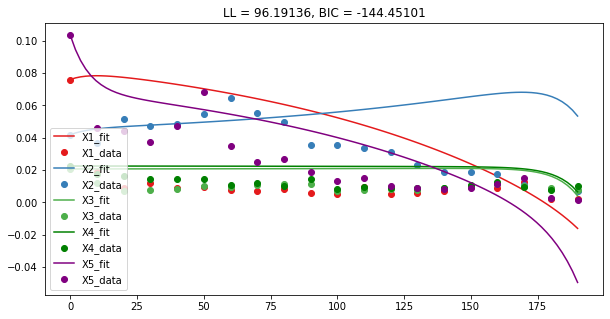

In [81]:
M1 = np.array([[1,0,0,0,1], [0,1,0,0,1], [0,0,1,1,0],[0,0,1,1,0],[1,1,0,0,1]])
theta_ML = fit_model(M1)
plot_fit(M1,theta_ML)

In [47]:
#TEST
opt_M = []
s = []

for m in M : 
    if (np.linalg.det(m) != 0):
        opt_M.append(greedy_hill_climbing(m)) #we run the algorithm for each of the starting matrix 
        s.append(score(m)) #compute the score of the optimized matrix

best_M = opt_M[s.index(max(s))]

neighborhood size : 20


KeyboardInterrupt: 

## Compute the score with likelihood and BIC

In [119]:
def score(M):
    '''
    cumpute the score of a graph
    
    '''
    return 0